In [1]:
# English
import numpy as np
import pandas as pd

train_en = pd.read_csv("NTCIR-13_MedWeb_en_training.csv")
test_en = pd.read_csv("NTCIR-13_MedWeb_en_test.csv")

# remove punctuation inside
import re
def  clean_text_en(df, text_field): 
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

# update 
train_en = clean_text_en(train_en,"Tweet")
test_en = clean_text_en(test_en,"Tweet")

print('Processing text dataset >>>')
from nltk.tokenize import RegexpTokenizer
from collections import Counter

tokenizer = RegexpTokenizer(r'\w+')
def text_to_wordlist(text, lower=False):
    # Tokenize
    text = tokenizer.tokenize(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in list_sentences:
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

list_train = list(train_en.Tweet)
list_test = list(test_en.Tweet)

tweet_train_en = process_comments(list_train)
tweet_test_en = process_comments(list_test)

print('Build word2vec model using Gensim')

from gensim.models import Word2Vec
model = Word2Vec(tweet_train_en, size=100, window=3, min_count=1, sg=1, negative=15)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train_en)

X_train = tokenizer.texts_to_sequences(tweet_train_en)
X_test = tokenizer.texts_to_sequences(tweet_test_en)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

word_index = tokenizer.word_index
# word_index.items()

from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

EMBEDDING_DIM=100
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = word_vectors[word]
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

list_classes = ["Influenza", "Diarrhea","Hayfever","Cough","Headache","Fever","Runnynose","Cold"]
result_train = train_en[list_classes].replace({'n':0, 'p':+1})
y_train = result_train[list_classes].values

result_test = test_en[list_classes].replace({'n':0, 'p':+1})
y_test = result_test[list_classes].values

Processing text dataset >>>
Build word2vec model using Gensim
Number of word vectors: 1814


Using TensorFlow backend.


In [2]:
from keras.layers import LSTM, Dense, Embedding
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


model = Sequential()
embedding_layer = Embedding(vocab_size,
                     EMBEDDING_DIM,
                     mask_zero=False,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2,recurrent_dropout=0.1)))
# model.add(BatchNormalization())
model.add(Dense(8,activation='sigmoid'))

optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
) # add early stopping

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=128,
                    validation_data=(X_test, y_test),callbacks=[es])

/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1920 samples, validate on 640 samples
Epoch 1/50
 - 6s - loss: 0.5474 - accuracy: 0.8355 - val_loss: 0.3698 - val_accuracy: 0.8834
Epoch 2/50
 - 3s - loss: 0.3793 - accuracy: 0.8754 - val_loss: 0.3551 - val_accuracy: 0.8834
Epoch 3/50
 - 3s - loss: 0.3694 - accuracy: 0.8754 - val_loss: 0.3510 - val_accuracy: 0.8834
Epoch 4/50
 - 4s - loss: 0.3674 - accuracy: 0.8754 - val_loss: 0.3508 - val_accuracy: 0.8834
Epoch 5/50
 - 3s - loss: 0.3660 - accuracy: 0.8754 - val_loss: 0.3494 - val_accuracy: 0.8834
Epoch 6/50
 - 2s - loss: 0.3648 - accuracy: 0.8754 - val_loss: 0.3480 - val_accuracy: 0.8834
Epoch 7/50
 - 2s - loss: 0.3642 - accuracy: 0.8754 - val_loss: 0.3465 - val_accuracy: 0.8834
Epoch 8/50
 - 2s - loss: 0.3628 - accuracy: 0.8754 - val_loss: 0.3475 - val_accuracy: 0.8834
Epoch 9/50
 - 2s - loss: 0.3619 - accuracy: 0.8754 - val_loss: 0.3427 - val_accuracy: 0.8834
Epoch 10/50
 - 2s - loss: 0.3577 - accuracy: 0.8754 - val_loss: 0.3402 - val_accuracy: 0.8834
Epoch 11/50
 - 3s - lo

In [3]:
# calculate metrics
pred_test = model.predict(X_test)
classes = pred_test > 0.5
pred_test = classes.astype(int) # update predicted value

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# initialize
ac = 0 
pre = 0
rec = 0
f1_s = 0

for i in range (0,8):
    
    prediction = pred_test[:, i]
    y_sys = y_test[:,i]
    print(list_classes[i])
    print('\nTest accuracy is {}'.format(accuracy_score(y_sys, prediction)))
    print('Test precision is {}'.format(precision_score(y_sys, prediction, average='binary')))
    print('Test recall is {}'.format(recall_score(y_sys, prediction, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_sys, prediction, average='binary')))
    
    temp_accuracy = accuracy_score(y_sys, prediction)
    ac = ac + temp_accuracy
    
    temp_precision = precision_score(y_sys, prediction, average='binary')
    pre = pre + temp_precision
    
    temp_recall = recall_score(y_sys, prediction, average='binary')
    rec = rec + temp_recall
    
    temp_f1_score = f1_score(y_sys, prediction, average='binary')
    f1_s= f1_s + temp_f1_score

print("Summary\n>>>>>>>>>>>>>>>>>>>>>\n")
ava_accuracy = ac/8
print('The average accuracy is {}'.format(ava_accuracy))

ava_precision = pre/8
print('The average precision is {}'.format(ava_precision))

ava_recall = rec/8
print('The average recall is {}'.format(ava_recall))

ava_f1_score = f1_s/8
print('The average f1 score is {}'.format(ava_f1_score))

Influenza

Test accuracy is 0.9640625
Test precision is 0.5151515151515151
Test recall is 0.7083333333333334
Test f1-score is 0.5964912280701754

Diarrhea

Test accuracy is 0.959375
Test precision is 0.8275862068965517
Test recall is 0.75
Test f1-score is 0.7868852459016394

Hayfever

Test accuracy is 0.9734375
Test precision is 0.8222222222222222
Test recall is 0.8043478260869565
Test f1-score is 0.8131868131868132

Cough

Test accuracy is 0.971875
Test precision is 0.918918918918919
Test recall is 0.85
Test f1-score is 0.8831168831168831

Headache

Test accuracy is 0.975
Test precision is 0.9066666666666666
Test recall is 0.8831168831168831
Test f1-score is 0.894736842105263

Fever

Test accuracy is 0.946875
Test precision is 0.8314606741573034
Test recall is 0.7956989247311828
Test f1-score is 0.8131868131868132

Runnynose

Test accuracy is 0.9125
Test precision is 0.8252427184466019
Test recall is 0.6910569105691057
Test f1-score is 0.7522123893805309

Cold

Test accuracy is 0.9546

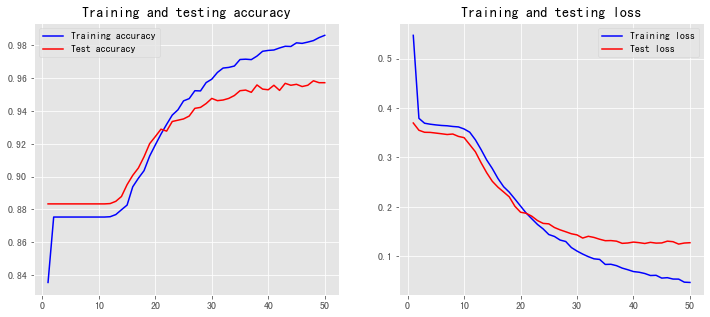

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Test accuracy')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and testing loss')
    plt.legend()
    plt.savefig("lstm_en.jpg")
plot_history(history)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, rankdir="LR", show_layer_names=False)

In [6]:
# Chinese

import pandas as pd
import numpy as np

train_zh = pd.read_csv("NTCIR-13_MedWeb_zh_training.csv", na_values='NaN',keep_default_na=False)
test_zh = pd.read_csv("NTCIR-13_MedWeb_zh_test.csv", na_values='NaN',keep_default_na=False)
test_zh = test_zh[:640]

# remove punctuation inside
import re
from zhon.hanzi import punctuation

def clean_text_zh(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem:re.sub(r'[{}]+'.format(punctuation),'',elem))
    return df

# update 
train_zh = clean_text_zh(train_zh,"Tweet")
test_zh = clean_text_zh(test_zh,"Tweet")

tweet_train_zh = list(train_zh.Tweet)
tweet_test_zh = list(test_zh.Tweet)

# introducing tokenizer
import jieba

def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# Tokenization
tweet_train_zh = [list(jieba.cut(i)) for i in tweet_train_zh]
tweet_test_zh = [list(jieba.cut(i)) for i in tweet_test_zh]

print('Build word2vec model using Gensim')

from gensim.models import Word2Vec
model = Word2Vec(tweet_train_zh, size=100, window=3, min_count=1, workers=3, sg=1)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train_zh)

X_train = tokenizer.texts_to_sequences(tweet_train_zh)
X_test = tokenizer.texts_to_sequences(tweet_test_zh)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

word_index = tokenizer.word_index

from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

EMBEDDING_DIM=100
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = word_vectors[word]
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/xz/jrlb55l167x3c2jq466bx5fm0000gn/T/jieba.cache
Loading model cost 0.949 seconds.
Prefix dict has been built successfully.


Build word2vec model using Gensim
Number of word vectors: 2292


In [7]:
list_classes = ["Influenza", "Diarrhea","Hayfever","Cough","Headache","Fever","Runnynose","Cold"]
result_train = train_zh[list_classes].replace({'n':0, 'p':+1})
y_train = result_train[list_classes].values

result_test = test_zh[list_classes].replace({'n':0, 'p':+1})
y_test = result_test[list_classes].values

from keras.layers import LSTM, Dense, Embedding
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


model = Sequential()
embedding_layer = Embedding(vocab_size,
                     EMBEDDING_DIM,
                     mask_zero=False,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.1,recurrent_dropout=0.1)))
# model.add(BatchNormalization())
model.add(Dense(8,activation='sigmoid'))

optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
) # add early stopping

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=128,
                    validation_data=(X_test, y_test),callbacks=[es])

/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1919 samples, validate on 640 samples
Epoch 1/50
 - 4s - loss: 0.5864 - accuracy: 0.8510 - val_loss: 0.4031 - val_accuracy: 0.8834
Epoch 2/50
 - 4s - loss: 0.3859 - accuracy: 0.8754 - val_loss: 0.3543 - val_accuracy: 0.8834
Epoch 3/50
 - 4s - loss: 0.3694 - accuracy: 0.8754 - val_loss: 0.3517 - val_accuracy: 0.8834
Epoch 4/50
 - 4s - loss: 0.3687 - accuracy: 0.8754 - val_loss: 0.3506 - val_accuracy: 0.8834
Epoch 5/50
 - 3s - loss: 0.3660 - accuracy: 0.8754 - val_loss: 0.3492 - val_accuracy: 0.8834
Epoch 6/50
 - 3s - loss: 0.3650 - accuracy: 0.8754 - val_loss: 0.3486 - val_accuracy: 0.8834
Epoch 7/50
 - 3s - loss: 0.3629 - accuracy: 0.8754 - val_loss: 0.3462 - val_accuracy: 0.8834
Epoch 8/50
 - 3s - loss: 0.3610 - accuracy: 0.8754 - val_loss: 0.3430 - val_accuracy: 0.8834
Epoch 9/50
 - 3s - loss: 0.3568 - accuracy: 0.8754 - val_loss: 0.3386 - val_accuracy: 0.8834
Epoch 10/50
 - 3s - loss: 0.3479 - accuracy: 0.8754 - val_loss: 0.3247 - val_accuracy: 0.8834
Epoch 11/50
 - 3s - lo

In [8]:
# calculate metrics
pred_test = model.predict(X_test)
classes = pred_test > 0.5
pred_test = classes.astype(int) # update predicted value

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# initialize
ac = 0 
pre = 0
rec = 0
f1_s = 0

for i in range (0,8):
    
    prediction = pred_test[:, i]
    y_sys = y_test[:,i]
    print(list_classes[i])
    print('\nTest accuracy is {}'.format(accuracy_score(y_sys, prediction)))
    print('Test precision is {}'.format(precision_score(y_sys, prediction, average='binary')))
    print('Test recall is {}'.format(recall_score(y_sys, prediction, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_sys, prediction, average='binary')))
    
    temp_accuracy = accuracy_score(y_sys, prediction)
    ac = ac + temp_accuracy
    
    temp_precision = precision_score(y_sys, prediction, average='binary')
    pre = pre + temp_precision
    
    temp_recall = recall_score(y_sys, prediction, average='binary')
    rec = rec + temp_recall
    
    temp_f1_score = f1_score(y_sys, prediction, average='binary')
    f1_s= f1_s + temp_f1_score

print("Summary\n>>>>>>>>>>>>>>>>>>>>>\n")
ava_accuracy = ac/8
print('The average accuracy is {}'.format(ava_accuracy))

ava_precision = pre/8
print('The average precision is {}'.format(ava_precision))

ava_recall = rec/8
print('The average recall is {}'.format(ava_recall))

ava_f1_score = f1_s/8
print('The average f1 score is {}'.format(ava_f1_score))

Influenza

Test accuracy is 0.9796875
Test precision is 0.7037037037037037
Test recall is 0.7916666666666666
Test f1-score is 0.7450980392156864

Diarrhea

Test accuracy is 0.9765625
Test precision is 0.855072463768116
Test recall is 0.921875
Test f1-score is 0.887218045112782

Hayfever

Test accuracy is 0.9796875
Test precision is 0.8666666666666667
Test recall is 0.8478260869565217
Test f1-score is 0.8571428571428571

Cough

Test accuracy is 0.971875
Test precision is 0.918918918918919
Test recall is 0.85
Test f1-score is 0.8831168831168831

Headache

Test accuracy is 0.96875
Test precision is 0.8701298701298701
Test recall is 0.8701298701298701
Test f1-score is 0.8701298701298701

Fever

Test accuracy is 0.9359375
Test precision is 0.7708333333333334
Test recall is 0.7956989247311828
Test f1-score is 0.7830687830687831

Runnynose

Test accuracy is 0.9296875
Test precision is 0.8482142857142857
Test recall is 0.7723577235772358
Test f1-score is 0.8085106382978723

Cold

Test accuracy

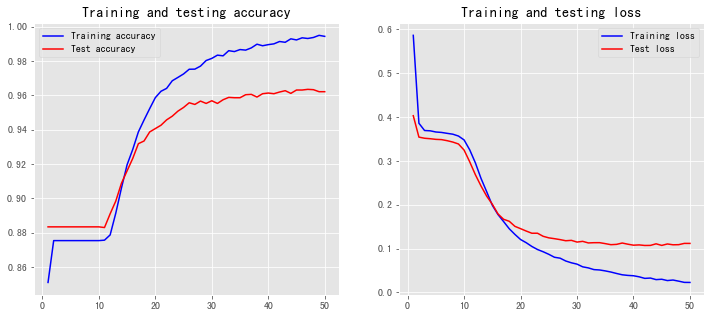

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Test accuracy')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and testing loss')
    plt.legend()
    plt.savefig("lstm_zh.jpg")
plot_history(history)

In [10]:
# japanese
import pandas as pd
import numpy as np

train_ja = pd.read_csv("NTCIR-13_MedWeb_ja_training.csv", na_values='NaN',keep_default_na=False)
test_ja = pd.read_csv("NTCIR-13_MedWeb_ja_test.csv", na_values='NaN',keep_default_na=False)
test_ja = test_ja[:640]

# remove punctuation inside
import re
from zhon.hanzi import punctuation

def clean_text_ja(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem:re.sub(r'[{}]+'.format(punctuation),'',elem))
    return df

# update 
train_ja = clean_text_ja(train_ja,"Tweet")
test_ja = clean_text_ja(test_ja,"Tweet")

# setup Japanese tokenizer
import nagisa

def tokenize_jp(doc):
    doc = nagisa.tagging(doc)
    return doc.words

tweet_train_ja = [list(tokenize_jp(i)) for i in train_ja.Tweet]
tweet_test_ja = [list(tokenize_jp(i)) for i in test_ja.Tweet]

print('Build word2vec model using Gensim')

from gensim.models import Word2Vec
model = Word2Vec(tweet_train_ja, size=100, window=5, min_count=1, workers=3, sg=1, negative=15)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train_ja)

X_train = tokenizer.texts_to_sequences(tweet_train_ja)
X_test = tokenizer.texts_to_sequences(tweet_test_ja)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

word_index = tokenizer.word_index

from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

EMBEDDING_DIM=100
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = word_vectors[word]
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
list_classes = ["Influenza", "Diarrhea","Hayfever","Cough","Headache","Fever","Runnynose","Cold"]
result_train = train_ja[list_classes].replace({'n':0, 'p':+1})
y_train = result_train[list_classes].values

result_test = test_ja[list_classes].replace({'n':0, 'p':+1})
y_test = result_test[list_classes].values

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 2161 word types from a corpus of 23974 raw words and 1920 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 2161 unique words (100% of original 2161, drops 0)
effective_min_count=1 leaves 23974 word corpus (100% of original 23974, drops 0)
deleting the raw counts dictionary of 2161 items
sample=0.001 downsamples 51 most-common words
downsampling leaves estimated 14748 word corpus (61.5% of prior 23974)
estimated required memory for 2161 words and 100 dimensions: 2809300 bytes
resetting layer weights


Build word2vec model using Gensim


training model with 3 workers on 2161 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=15 window=5
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 23974 raw words (14696 effective words) took 0.1s, 141309 effective words/s
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 23974 raw words (14791 effective words) took 0.1s, 122093 effective words/s
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 3 : training on 23974 raw words (14752 effective words) took 0.0s, 304280 effective words/s
worker thread finished; awaiting finish of 2 more threads
wor

Number of word vectors: 2161


In [11]:

from keras.layers import LSTM, Dense, Embedding
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


model = Sequential()
embedding_layer = Embedding(vocab_size,
                     EMBEDDING_DIM,
                     mask_zero=False,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.1,recurrent_dropout=0.1)))
# model.add(BatchNormalization())
model.add(Dense(8,activation='sigmoid'))

optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
) # add early stopping

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=64,
                    validation_data=(X_test, y_test),callbacks=[es])

/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1920 samples, validate on 640 samples
Epoch 1/50
 - 6s - loss: 0.4568 - accuracy: 0.8658 - val_loss: 0.3535 - val_accuracy: 0.8834
Epoch 2/50
 - 4s - loss: 0.3678 - accuracy: 0.8754 - val_loss: 0.3499 - val_accuracy: 0.8834
Epoch 3/50
 - 4s - loss: 0.3636 - accuracy: 0.8754 - val_loss: 0.3461 - val_accuracy: 0.8834
Epoch 4/50
 - 5s - loss: 0.3582 - accuracy: 0.8754 - val_loss: 0.3383 - val_accuracy: 0.8834
Epoch 5/50
 - 4s - loss: 0.3451 - accuracy: 0.8754 - val_loss: 0.3174 - val_accuracy: 0.8840
Epoch 6/50
 - 4s - loss: 0.3158 - accuracy: 0.8776 - val_loss: 0.2794 - val_accuracy: 0.8889
Epoch 7/50
 - 3s - loss: 0.2784 - accuracy: 0.8851 - val_loss: 0.2531 - val_accuracy: 0.8951
Epoch 8/50
 - 3s - loss: 0.2499 - accuracy: 0.8927 - val_loss: 0.2210 - val_accuracy: 0.9000
Epoch 9/50
 - 4s - loss: 0.2160 - accuracy: 0.9084 - val_loss: 0.2005 - val_accuracy: 0.9145
Epoch 10/50
 - 3s - loss: 0.1893 - accuracy: 0.9278 - val_loss: 0.1789 - val_accuracy: 0.9320
Epoch 11/50
 - 3s - lo

In [12]:
# calculate metrics
pred_test = model.predict(X_test)
classes = pred_test > 0.5
pred_test = classes.astype(int) # update predicted value

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# initialize
ac = 0 
pre = 0
rec = 0
f1_s = 0

for i in range (0,8):
    
    prediction = pred_test[:, i]
    y_sys = y_test[:,i]
    print(list_classes[i])
    print('\nTest accuracy is {}'.format(accuracy_score(y_sys, prediction)))
    print('Test precision is {}'.format(precision_score(y_sys, prediction, average='binary')))
    print('Test recall is {}'.format(recall_score(y_sys, prediction, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_sys, prediction, average='binary')))
    
    temp_accuracy = accuracy_score(y_sys, prediction)
    ac = ac + temp_accuracy
    
    temp_precision = precision_score(y_sys, prediction, average='binary')
    pre = pre + temp_precision
    
    temp_recall = recall_score(y_sys, prediction, average='binary')
    rec = rec + temp_recall
    
    temp_f1_score = f1_score(y_sys, prediction, average='binary')
    f1_s= f1_s + temp_f1_score

print("Summary\n>>>>>>>>>>>>>>>>>>>>>\n")
ava_accuracy = ac/8
print('The average accuracy is {}'.format(ava_accuracy))

ava_precision = pre/8
print('The average precision is {}'.format(ava_precision))

ava_recall = rec/8
print('The average recall is {}'.format(ava_recall))

ava_f1_score = f1_s/8
print('The average f1 score is {}'.format(ava_f1_score))

Influenza

Test accuracy is 0.978125
Test precision is 0.7272727272727273
Test recall is 0.6666666666666666
Test f1-score is 0.6956521739130435

Diarrhea

Test accuracy is 0.978125
Test precision is 0.9032258064516129
Test recall is 0.875
Test f1-score is 0.8888888888888888

Hayfever

Test accuracy is 0.9859375
Test precision is 0.8936170212765957
Test recall is 0.9130434782608695
Test f1-score is 0.9032258064516129

Cough

Test accuracy is 0.98125
Test precision is 0.925
Test recall is 0.925
Test f1-score is 0.925

Headache

Test accuracy is 0.978125
Test precision is 0.9315068493150684
Test recall is 0.8831168831168831
Test f1-score is 0.9066666666666665

Fever

Test accuracy is 0.94375
Test precision is 0.8064516129032258
Test recall is 0.8064516129032258
Test f1-score is 0.8064516129032258

Runnynose

Test accuracy is 0.953125
Test precision is 0.8842975206611571
Test recall is 0.8699186991869918
Test f1-score is 0.8770491803278687

Cold

Test accuracy is 0.9625
Test precision is 0

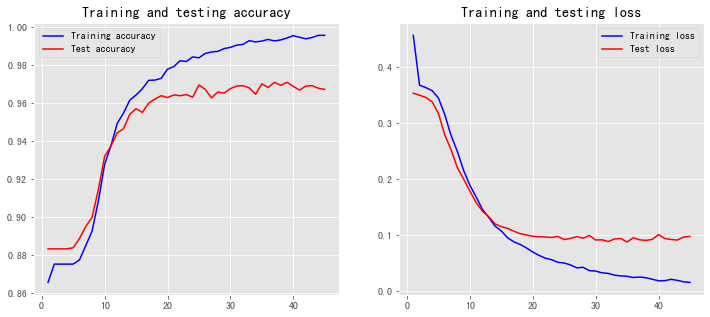

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Test accuracy')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and testing loss')
    plt.legend()
    plt.savefig("lstm_ja.jpg")
plot_history(history)